In [1]:
# ADD polarization 
# Debug
# Frequency domain
# Add the detrended

In [2]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
#import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from sklearn import *
import math
from sklearn import linear_model as lm  # Used for solving linear regression problems
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
plt.rcParams["figure.figsize"] = (20,10)
tf.autograph.set_verbosity(0)
import scipy.io
from numpy.linalg import norm 
import cmath
import math

In [3]:
from ipynb.fs.defs.UtilitiesAR import *


## Import Data


In [4]:
mpc = 640


In [5]:
carriers = 408
antennas = 32

In [6]:
data =  pd.read_csv("../../Baseline/PPCA/Baseline_UE1/Polar/UE1_data_unfold_arg_polar.csv", index_col=0)
data2 =  pd.read_csv("../../Baseline/PPCA/Baseline_UE1/Polar/UE1_data_unfold_arg_polar_2.csv", index_col=0)

In [7]:
mat = scipy.io.loadmat("../../Data/data_UE1_600/quadriga_ue1_snr10_avg10TTI_total600TTI_evalinterval1TTI_seed123.mat")
G0 = mat['param'][0][0][0]
estimate_mpc = mat['param'][0][0][2]
estimate_mpc_1SB = mat['param'][0][0][2][0:mpc,0,:]
estimate_mpc_1SB_pol2 = mat['param'][0][0][2][mpc:,0,:]

In [8]:
true_channel = scipy.io.loadmat('../../Data/data_UE1_600/channel_ue1.mat')


In [9]:
True_channel_1SB = true_channel['channel_ue'][:antennas, :carriers, ].transpose()
True_channel_1SB_pol2 = true_channel['channel_ue'][antennas:antennas*2, carriers:carriers*2, ].transpose()

# NMSE Estimated VS Real

In [10]:
estimate_channel = estimate_mpc_1SB.T.dot(G0.T).reshape(590,carriers, antennas)
estimate_channel_pol2 = estimate_mpc_1SB_pol2.T.dot(G0.T).reshape(590,carriers, antennas)

In [11]:
estimate_channel_pol2.shape

(590, 408, 32)

In [12]:
True_channel_1SB_11 = True_channel_1SB[10:,]

In [13]:
True_channel_1SB_pol2_1 = True_channel_1SB_pol2[10:,]

In [14]:
estimate_channel_both = np.concatenate([estimate_channel, estimate_channel_pol2], 2)
True_channel_both = np.concatenate([True_channel_1SB_11, True_channel_1SB_pol2_1], 2)

In [15]:
NMSE_TTI = [NMSE((True_channel_both[TTI,:,:]), (estimate_channel_both[TTI,:,:])) for TTI in range(estimate_channel_both.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Estimate Channel UE1 2 Polarisations')

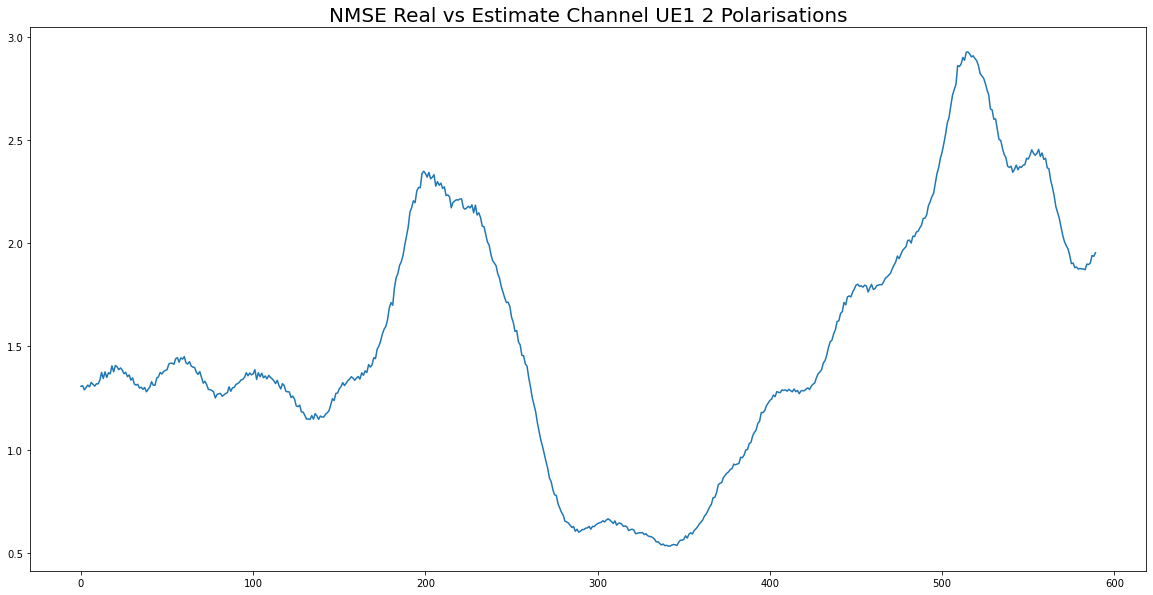

In [16]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Estimate Channel UE1 2 Polarisations', size=20)


In [17]:
NMSE_TTI = [NMSE((True_channel_1SB_11[TTI,:,:]), (estimate_channel[TTI,:,:])) for TTI in range(estimate_channel.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Estimate Channel UE1 Polarisation 1 ')

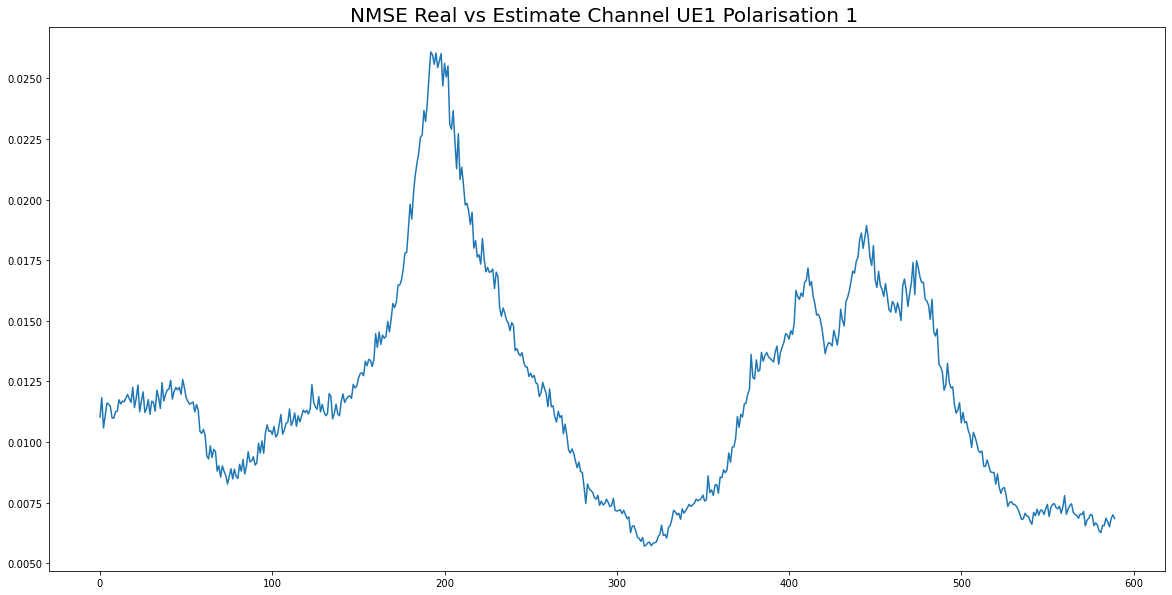

In [18]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Estimate Channel UE1 Polarisation 1 ', size=20)


In [19]:
NMSE_TTI = [NMSE((True_channel_1SB_pol2_1[TTI,:,:]), (estimate_channel_pol2[TTI,:,:])) for TTI in range(True_channel_1SB_pol2_1.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Estimate Channel UE1 Polarisation 2')

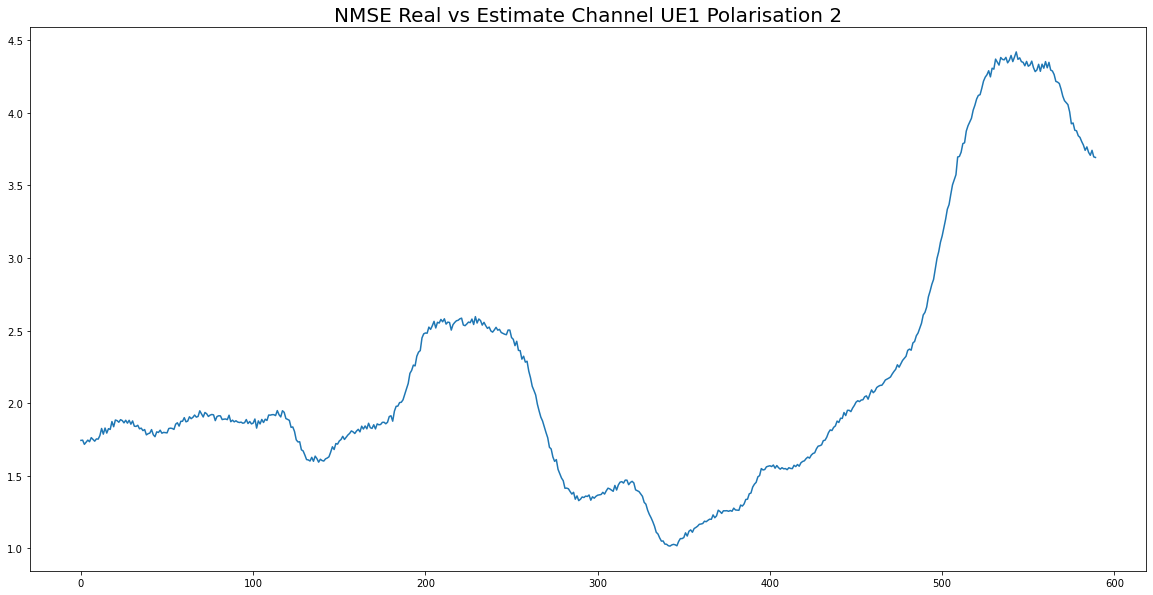

In [20]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Estimate Channel UE1 Polarisation 2', size=20)


### Arrangement of 1 SB

In [21]:
SB1 = data.iloc[:, :mpc*2]
mpc1 = SB1.iloc[:,0].to_numpy()

In [22]:
SB1_pol2 = data2.iloc[:, :mpc*2]
mpc1_pol2 = SB1_pol2.iloc[:,0].to_numpy()

In [23]:
model = lm.LinearRegression().fit(X = np.arange(len(mpc1)).reshape(len(mpc1),1), y = mpc1)

model_pol2 = lm.LinearRegression().fit(X = np.arange(len(mpc1_pol2)).reshape(len(mpc1_pol2),1), y = mpc1_pol2)


In [24]:
predictions = model.predict(np.arange(len(mpc1)).reshape(len(mpc1),1))
predictions_pol2 = model_pol2.predict(np.arange(len(mpc1_pol2)).reshape(len(mpc1_pol2),1))


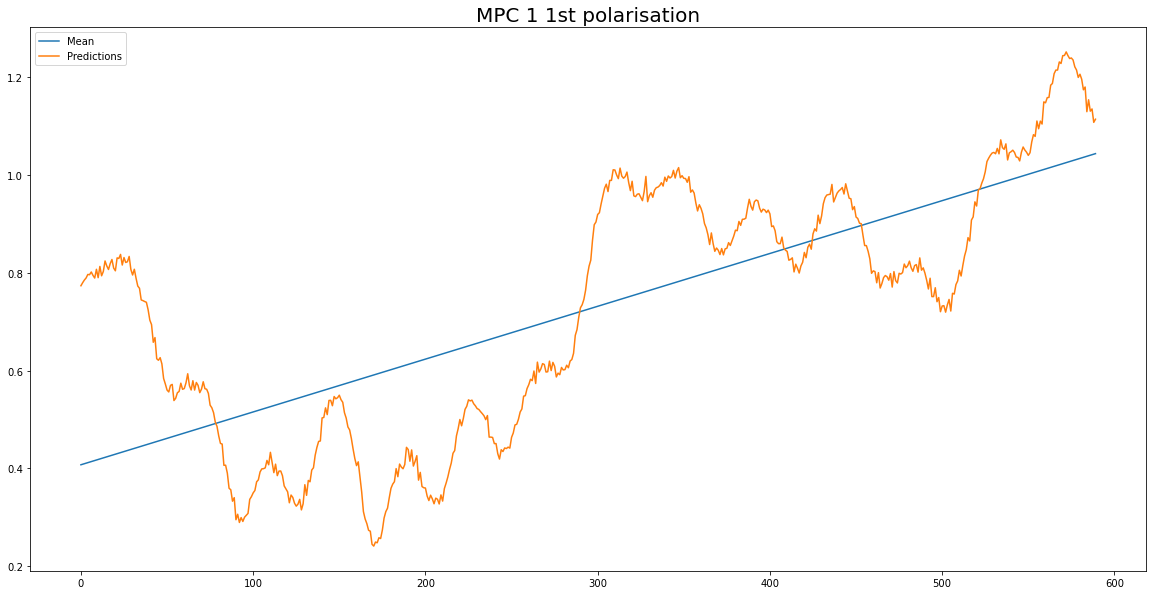

In [25]:
plt.plot(predictions, label="Mean")
plt.plot(mpc1, label="Predictions")
plt.title('MPC 1 1st polarisation', size=20)
plt.legend()
plt.show()

In [26]:
mpc1_no_mean = mpc1

In [27]:
#mpc1_no_mean = mpc1 - predictions

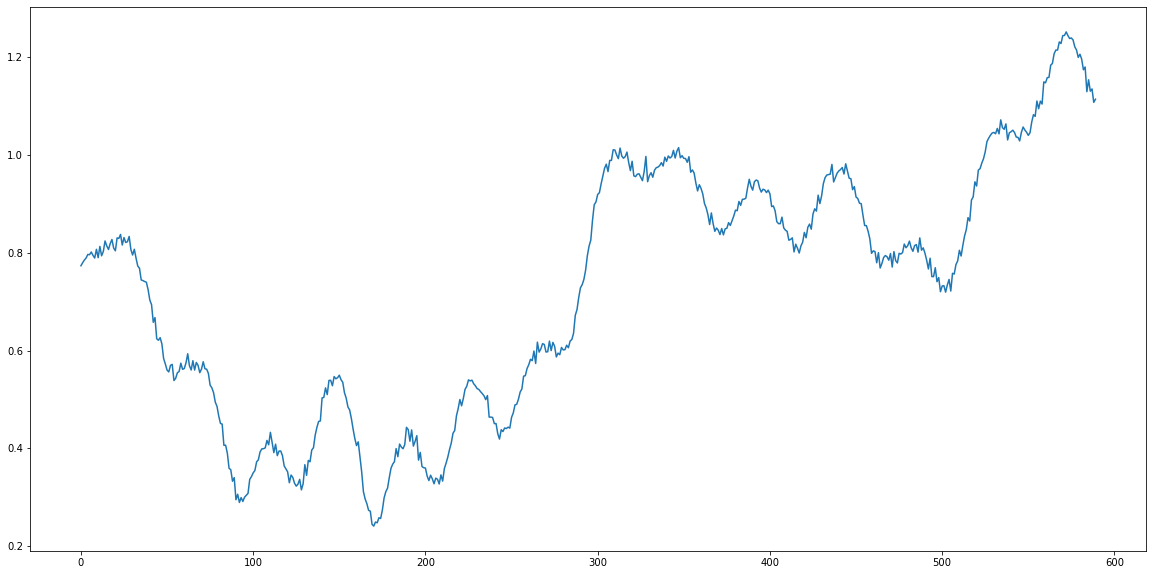

In [28]:
plot(mpc1_no_mean)


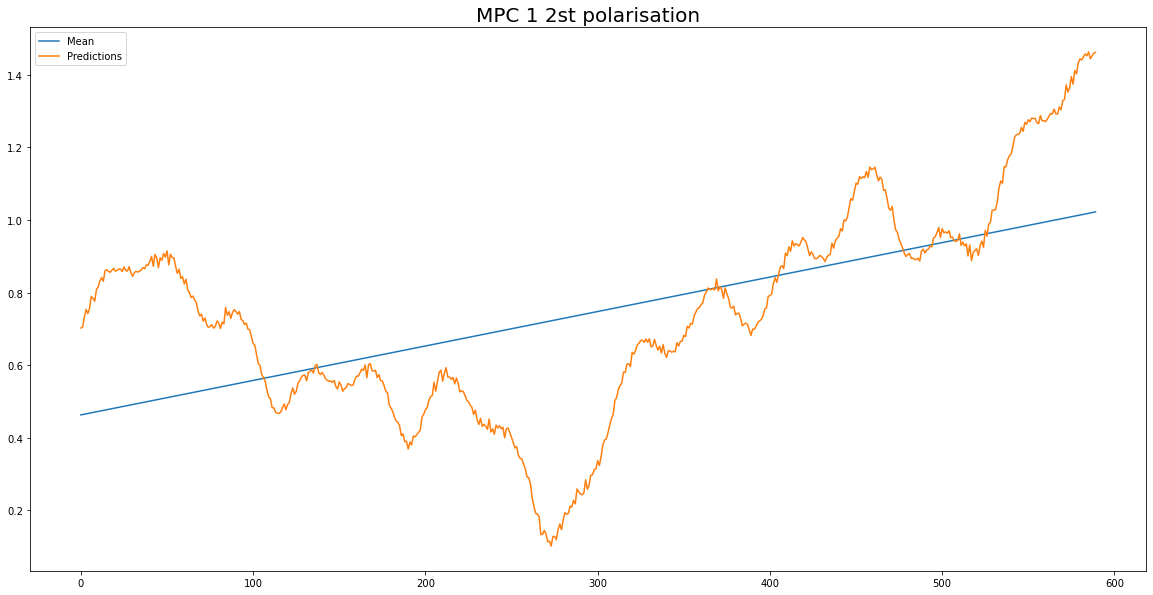

In [29]:
plt.plot(predictions_pol2, label="Mean")
plt.plot(mpc1_pol2, label="Predictions")
plt.title('MPC 1 2st polarisation', size=20)
plt.legend()
plt.show()

In [30]:
mpc1_no_mean_pol2 = mpc1_pol2

In [31]:
#mpc1_no_mean_pol2 = mpc1_pol2 - predictions_pol2

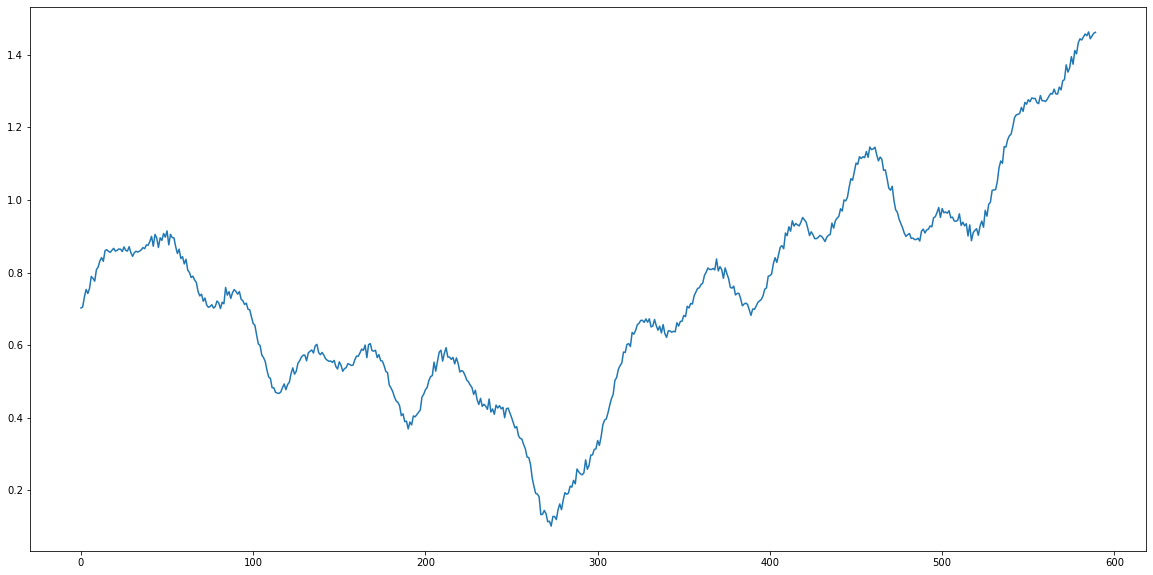

In [32]:
plot(mpc1_no_mean_pol2)


## Modeling of 1st MPC

In [33]:
train_size = 50

In [34]:
train_pol1 = mpc1_no_mean[:train_size]
test_pol1 = mpc1_no_mean[train_size:len(mpc1_no_mean)]
print("train data samples: {0}, test data samples {1}".format(len(train_pol1), len(test_pol1)))

train data samples: 50, test data samples 540


In [35]:
train_pol2 = mpc1_no_mean_pol2[:train_size]
test_pol2 = mpc1_no_mean_pol2[train_size:len(mpc1_no_mean_pol2)]

In [36]:
p=10

In [37]:
train_pol1 = np.expand_dims(train_pol1, 1)

coef = fit_ar(train_pol1, p)


In [38]:
train_pol2 = np.expand_dims(train_pol2, 1)

coef_pol2 = fit_ar(train_pol2, p)

In [39]:
predictions_all_pol1 = predict_ar_1step(coef, mpc1_no_mean)

In [40]:
predictions_all_pol2 = predict_ar_1step(coef_pol2, mpc1_no_mean_pol2)

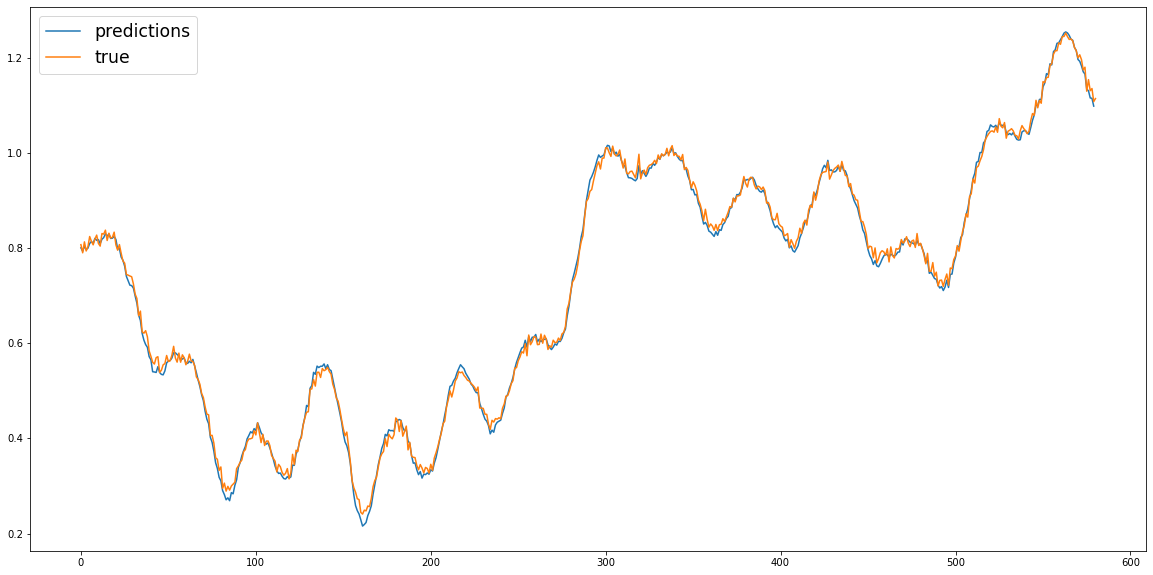

In [41]:
plt.plot(predictions_all_pol1[:-1], label = "predictions")
plt.plot(mpc1_no_mean[p-1:], label = "true")
plt.legend(fontsize='xx-large')
plt.show()

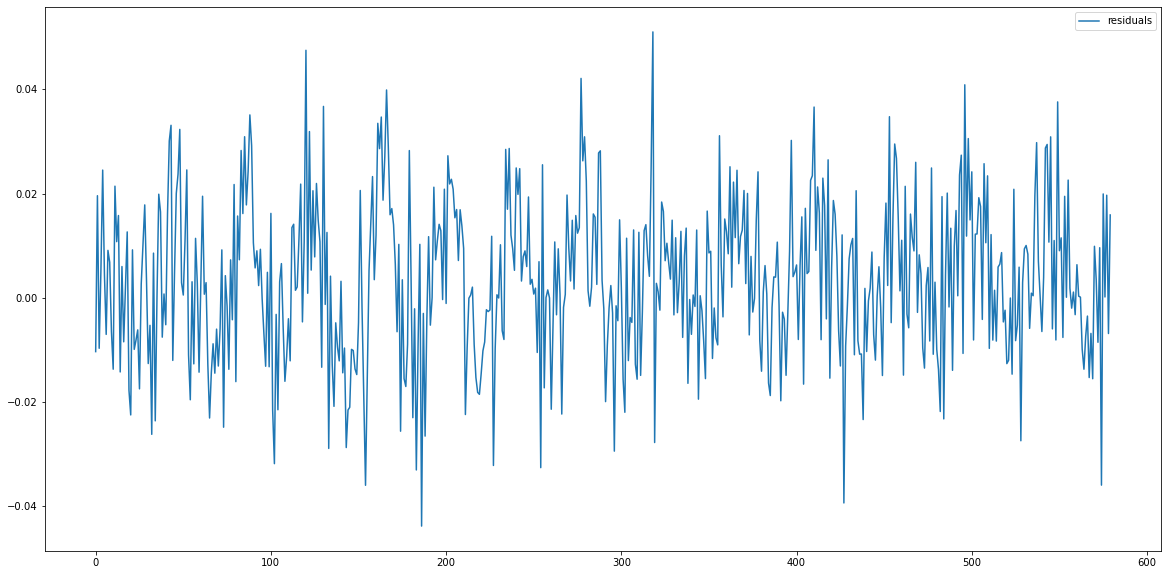

In [42]:
plt.plot(mpc1_no_mean[p:] - predictions_all_pol1[:-1], label = "residuals")
plt.legend()
plt.show()

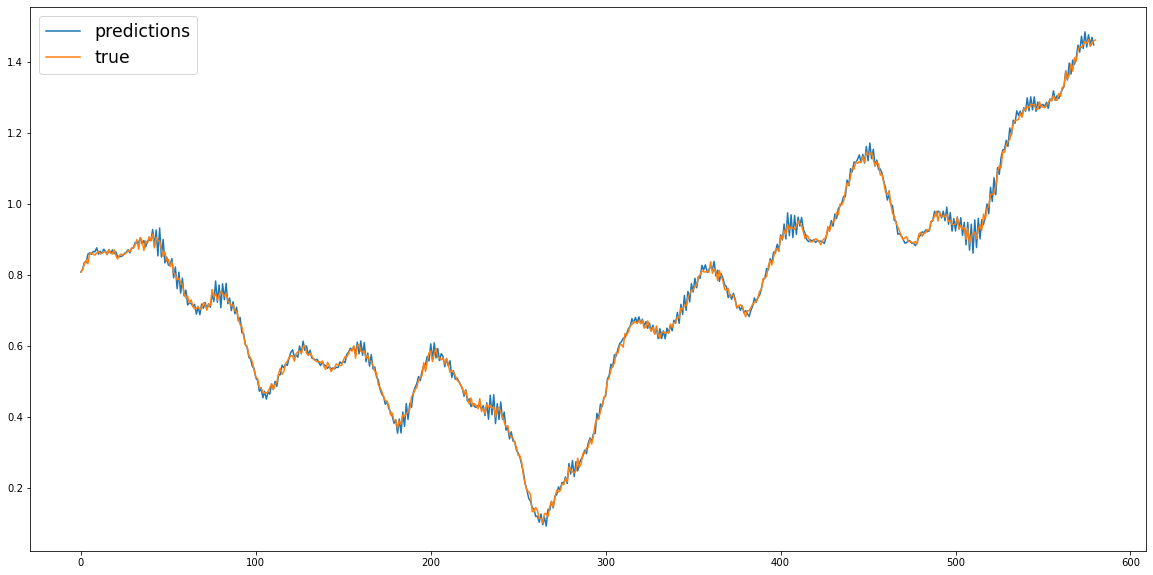

In [43]:
plt.plot(predictions_all_pol2[:-1], label = "predictions")
plt.plot(mpc1_no_mean_pol2[p-1:], label = "true")
plt.legend(fontsize='xx-large')
plt.show()

### Arrangement of Another less powerful MPC

In [44]:
nmpc=300

In [45]:

mpc1 = SB1.iloc[:,nmpc].to_numpy()

In [46]:
model = lm.LinearRegression().fit(X = np.arange(len(mpc1)).reshape(len(mpc1),1), y = mpc1)


In [47]:
predictions = model.predict(np.arange(len(mpc1)).reshape(len(mpc1),1))


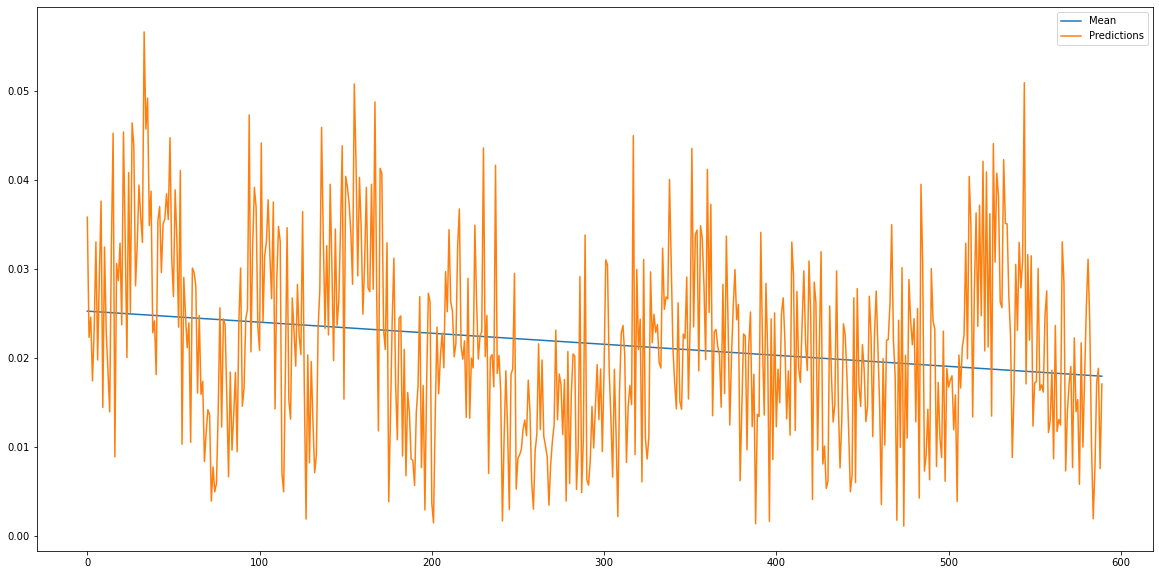

In [48]:
plt.plot(predictions, label="Mean")
plt.plot(mpc1, label="Predictions")
plt.legend()
plt.show()

In [49]:
data_no_mean = mpc1

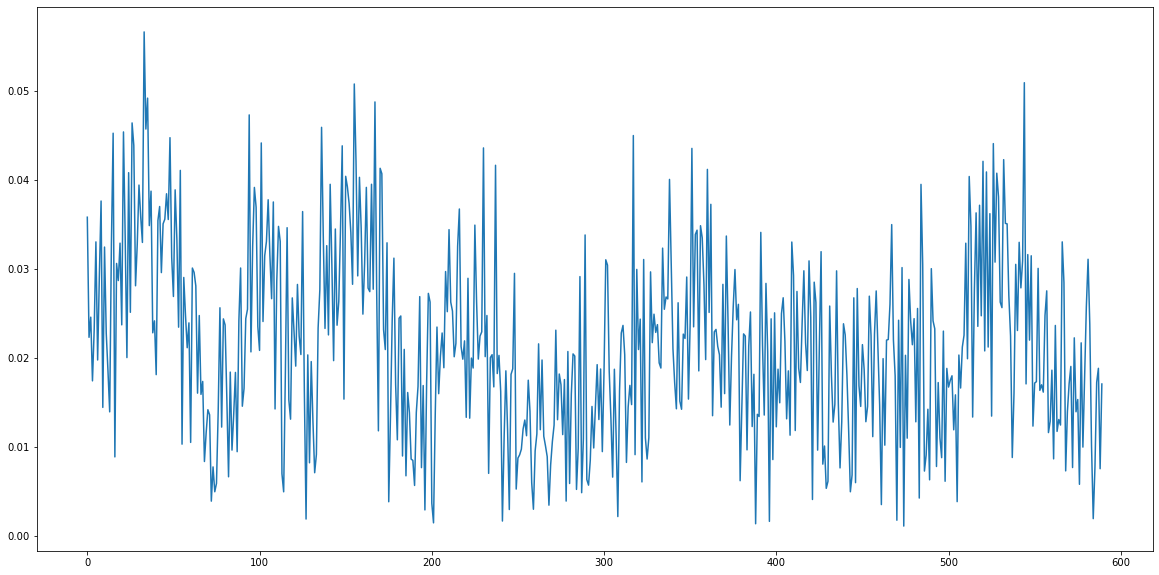

In [50]:
plot(data_no_mean)


In [51]:
train_size = 50

In [52]:
train = data_no_mean[:train_size]
test = data_no_mean[train_size:len(data_no_mean)]
print("train data samples: {0}, test data samples {1}".format(len(train), len(test)))

train data samples: 50, test data samples 540


In [53]:
train = np.expand_dims(train, 1)

coef = fit_ar(train, p)


In [54]:
predictions_all = predict_ar_1step(coef, data_no_mean)

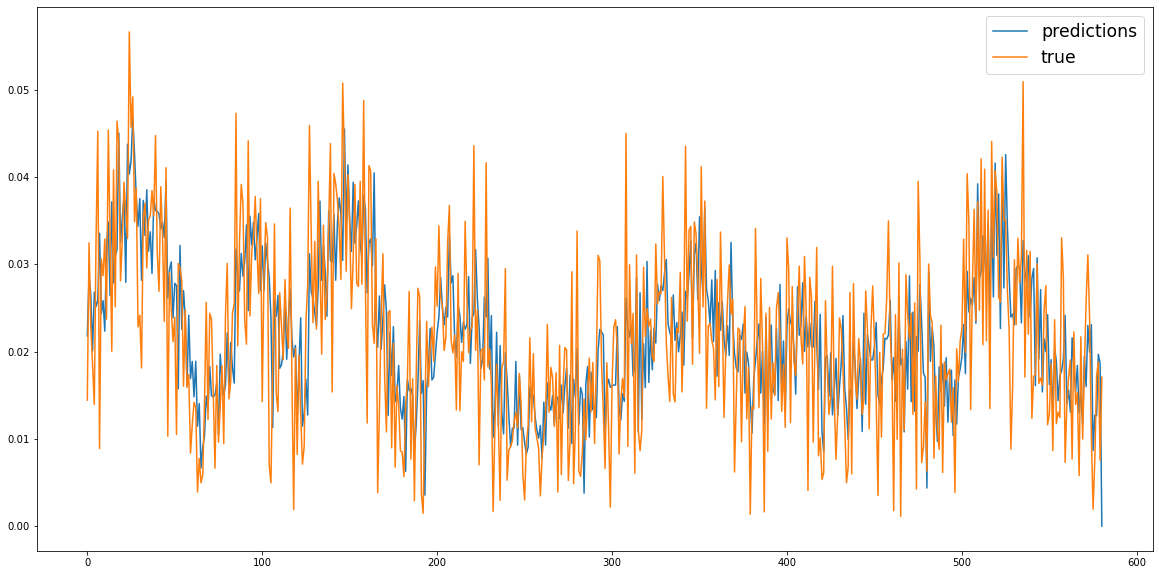

In [55]:
plt.plot(predictions_all, label = "predictions")
plt.plot(data_no_mean[p-1:], label = "true")
plt.legend(fontsize='xx-large')
plt.show()

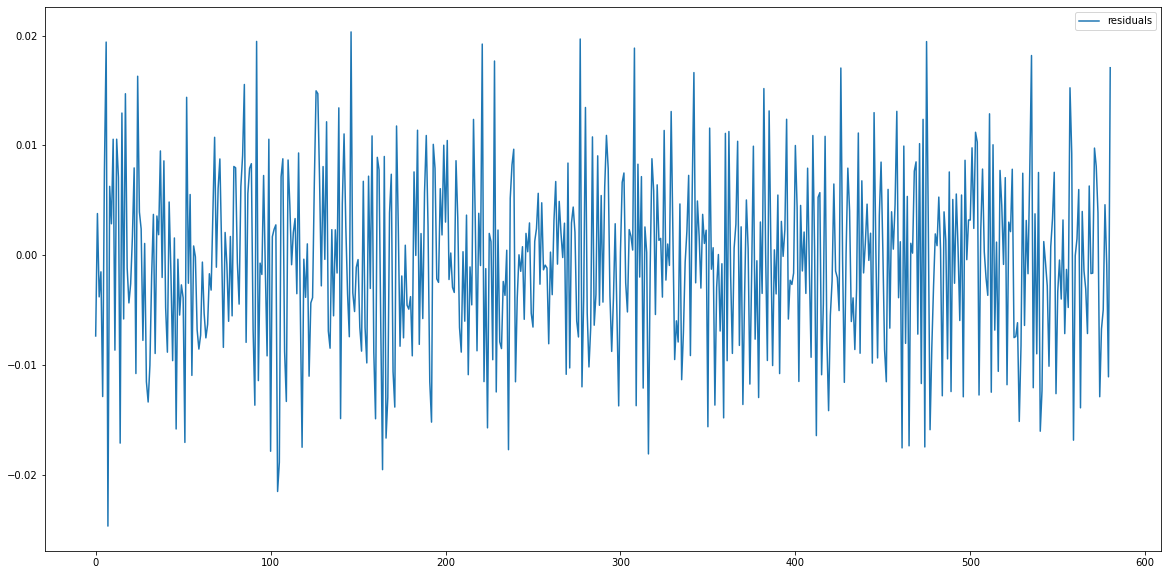

In [56]:
plt.plot(data_no_mean[p-1:] - predictions_all, label = "residuals")
plt.legend()
plt.show()

## All SB prediction 

In [57]:
from scipy import signal


In [58]:
mpc=640


In [59]:
SB1_mod = SB1.iloc[:,:mpc]

SB1_pha = SB1.iloc[:, mpc:mpc*2]
SB1_pha = SB1_pha.apply(np.unwrap)


In [60]:
SB1_mod_pol2 = SB1_pol2.iloc[:,:mpc]

SB1_pha_pol2 = SB1_pol2.iloc[:, mpc:mpc*2]
SB1_pha_pol2 = SB1_pha_pol2.apply(np.unwrap)


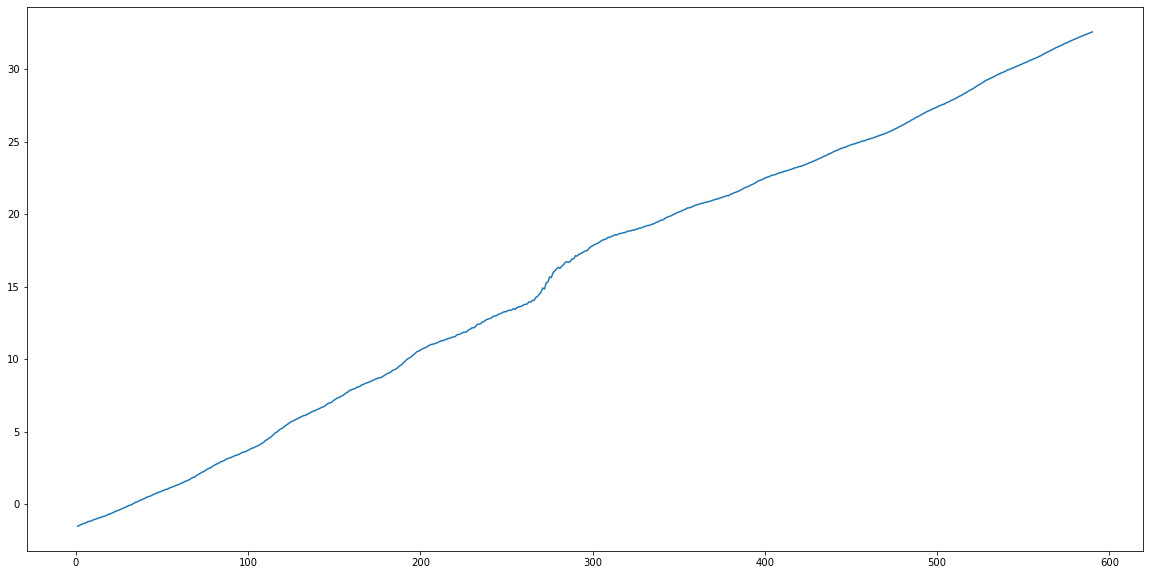

In [61]:
plot(SB1_pha_pol2.iloc[:,0])


## Training

### Prediction in Amplitudes

In [62]:
coef = [fit_ar(np.expand_dims((SB1_mod[x].values), 1), 10) for x in SB1_mod.iloc[:train_size,]]

In [63]:
coef_pol2 = [fit_ar(np.expand_dims((SB1_mod_pol2[x].values), 1), 10) for x in SB1_mod_pol2.iloc[:train_size,]]

In [64]:
predictions_all = [predict_ar_1step(coeff, SB1_mod[MPC].values) for coeff, MPC in zip(coef, SB1_mod)]

In [65]:
predictions_all_pol2 = [predict_ar_1step(coeff, SB1_mod_pol2[MPC].values) for coeff, MPC in zip(coef_pol2, SB1_mod_pol2)]

### Prediction in Polar

In [66]:
coef = [fit_ar(np.expand_dims((SB1_pha[x].values), 1), 10) for x in SB1_pha.iloc[:train_size,]]

In [67]:
coef_pol2 = [fit_ar(np.expand_dims((SB1_pha_pol2[x].values), 1), 10) for x in SB1_pha_pol2.iloc[:train_size,]]

In [68]:
predictions_all_pha = [predict_ar_1step(coeff, SB1_pha[MPC].values) for coeff, MPC in zip(coef, SB1_pha)]

In [69]:
predictions_all_pha_pol2 = [predict_ar_1step(coeff, SB1_pha_pol2[MPC].values) for coeff, MPC in zip(coef_pol2, SB1_pha_pol2)]

### Fold Dataframe

In [70]:

SB1_pred = pd.concat([pd.DataFrame(predictions_all).T, pd.DataFrame(predictions_all_pha).T], axis=1, 
          ignore_index=True)


In [71]:
SB1_pred = SB1_pred.iloc[:-1,]

In [72]:

SB1_pred_pol2 = pd.concat([pd.DataFrame(predictions_all_pol2).T, pd.DataFrame(predictions_all_pha_pol2).T], axis=1, 
          ignore_index=True)


In [73]:
SB1_pred_pol2 = SB1_pred_pol2.iloc[:-1,]

In [74]:
predicts_1SB = pd.DataFrame(reIm2complex_sb(SB1_pred))

In [75]:
predicts_1SB_pol2 = pd.DataFrame(reIm2complex_sb(SB1_pred_pol2))

In [76]:
N_TTIs_Pred = SB1_pred.shape[0]

In [77]:
pred_channel = predicts_1SB.values.dot(G0.T).reshape(N_TTIs_Pred,carriers, antennas)
pred_channel_pol2 = predicts_1SB_pol2.values.dot(G0.T).reshape(N_TTIs_Pred,carriers, antennas)

In [78]:
idxplot = np.arange(len(SB1_pha.iloc[10:,0]))

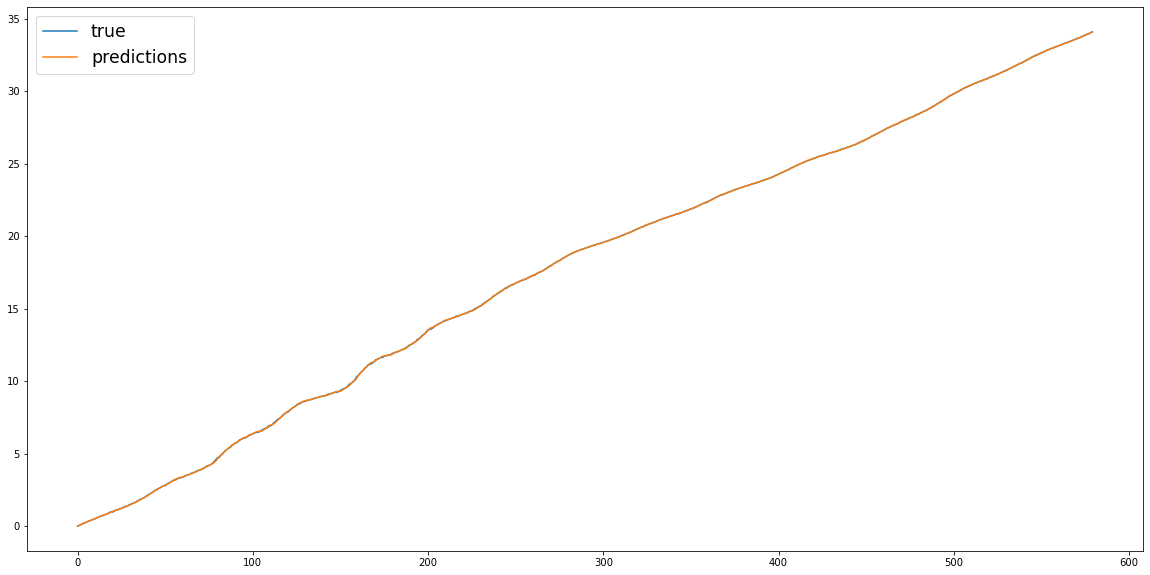

In [79]:
plot(idxplot, SB1_pha.iloc[10:,0], label = "true")
plot(idxplot, predictions_all_pha[0][:-1], label = "predictions")

#plt.plot(predictions_all, )
plt.legend(fontsize='xx-large')
plt.show()

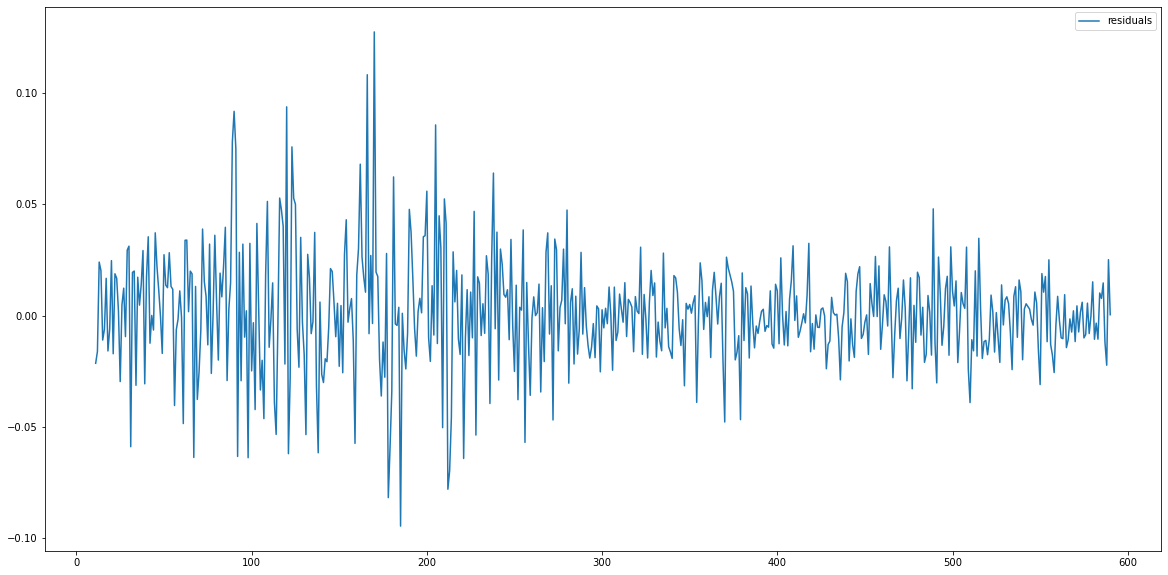

In [80]:
plt.plot(SB1_pha.iloc[10:,0] - predictions_all_pha[0][:-1], label = "residuals")
plt.legend()
plt.show()

## Transformation to Channel and NMSE

In [89]:
pred_channel_both = np.concatenate([pred_channel, pred_channel_pol2], 2)


In [90]:
True_channel_1SB__ = True_channel_1SB[10+p-1:-1,]
True_channel_1SB_pol2_1__ = True_channel_1SB_pol2_1[p-1:-1,]

In [91]:
NMSE_TTI = [NMSE((True_channel_1SB__[TTI,:,:]), (pred_channel[TTI,:,:])) for TTI in range(pred_channel.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Predicted Channel UE1  Polarisation 1')

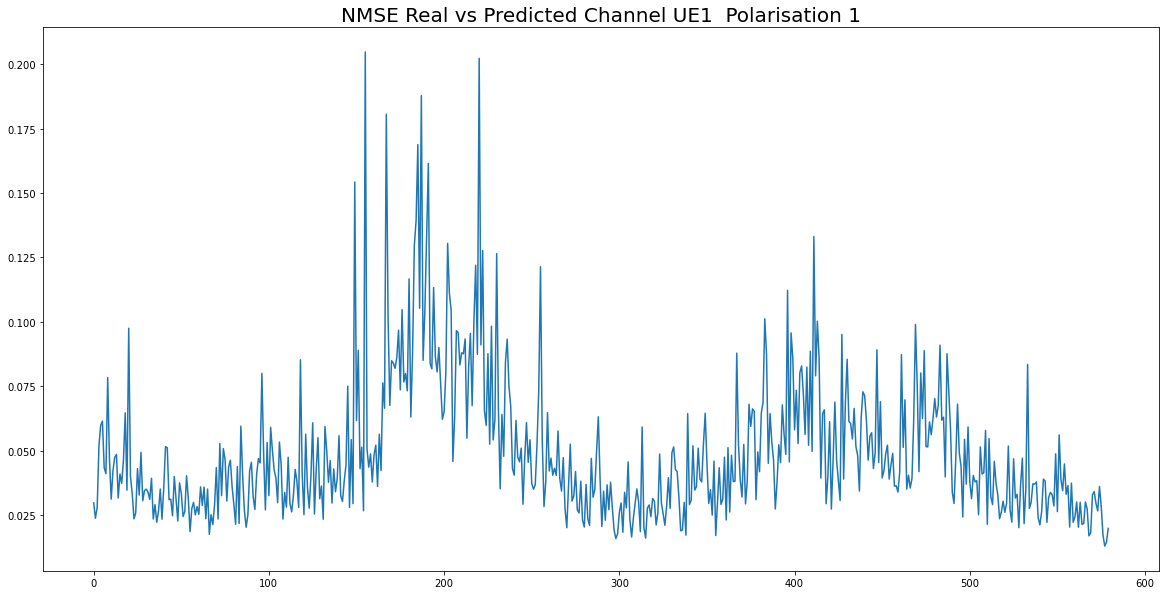

In [92]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Predicted Channel UE1  Polarisation 1', size=20)


In [93]:
NMSE_TTI = [NMSE((True_channel_1SB_pol2_1__[TTI,:,:]), (pred_channel_pol2[TTI,:,:])) for TTI in range(pred_channel_pol2.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Predicted Channel UE1  Polarisation 2')

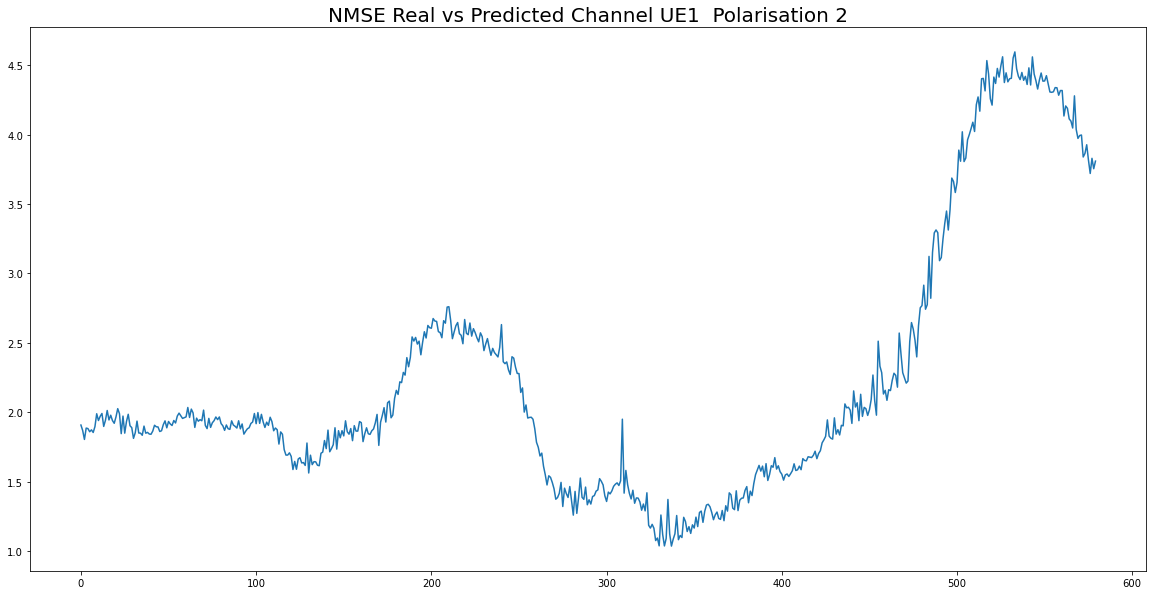

In [94]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Predicted Channel UE1  Polarisation 2', size=20)


In [95]:
NMSE_TTI = [NMSE(True_channel_both[TTI,:,:], pred_channel_both[TTI,:,:]) for TTI in range(pred_channel_both.shape[0])] 

Text(0.5, 1.0, 'NMSE Real vs Predicted Channel UE1 2 Polarisations')

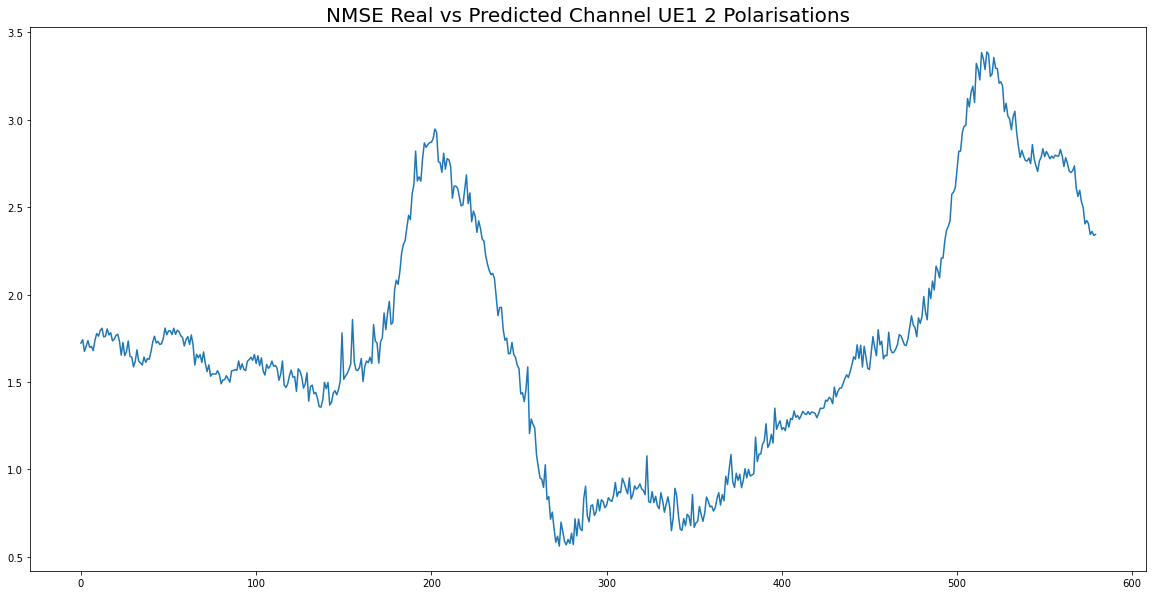

In [96]:
plot(NMSE_TTI)
plt.title('NMSE Real vs Predicted Channel UE1 2 Polarisations', size=20)


In [ ]:
plot(predictions_all_pol2[:,0])